# Run general analysis on autophagosome membranes

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv
from pyvistaqt import BackgroundPlotter

from sympy import solve, symbols

# Import custom functions
dir_utilities = Path('../utilities').resolve().as_posix()
if dir_utilities not in sys.path:
    sys.path.insert(0, dir_utilities)
    
from utility_functions import load_segmentation_tif, namedtuple_to_dict, dicts_all_equal, clean_pointlist_clustering 
from distance_functions import minimum_distance_refined
from fitting_functions import (ls_sphere_3, ellipsoid_fit_rmse, 
                               sphericity_of_ellipsoid, sphericity_index_ellipsoid, 
                               generate_ellipsoid_even, generate_sphere_even, 
                               ellipsoid_volume, ellipsoid_area_thomsen)
from fit_ellipsoid_weiss import fit_ellipsoid_iter, check_convergence_ellipsoid_fit


## Input

In [2]:
fname_in = Path('../example_data/autophagosome_analysis/AP_middle_labels.tif')
pix_size = 1.408

# Segmentation labels
seg_labels = {'inner': 1,
              'outer': 2}

# Parameters 
membrane_thickness = 5 # in nm, for estimating intermembrane lumen
n_iter_ellipsoid_fit = 10000 # Check plot if fit converged!
n_iter_ell_run2 = 50000 # If first fit didn't converge, try once more with this number of iterations
ellipsoid_fit_samplesize = 2000

clean_points_clustering = False # Whether to find outlier points with clustering

# Results dictionary for comparison
fname_compare = fname_in.parent / 'Autophagosome_results.npy'

In [3]:
# For visualization
window_size_0 = [512,512]
cpos = {'points': [(-647.6504826056222, 366.3476111712706, -834.2214686311667),
                  (379.92308704410544, 602.4065703933958, 165.30091188487296),
                  (0.6951335698709826, 0.01708633112263387, -0.7186775197035122)],
        'outliers': [(212.45059807417522, -222.6721481615132, -1051.4538023133018),
                  (390.5, 574.5, 150.0),
                  (0.9874322652525971, 0.01636819323263601, -0.15719288720684546)],
       'fits': [(495.9379222696108, 669.5843467010459, 1546.5021974500448),
                  (369.43722483176447, 635.0738749680415, 135.10582627514228),
                  (-0.9959760417423459, 0.010414198911870664, 0.08901274479687163)]}

## Load and process segmentation data

In [4]:
points = load_segmentation_tif(fname_in.as_posix(), seg_labels, verbose=True)

Input volume shape is (928, 928, 324)


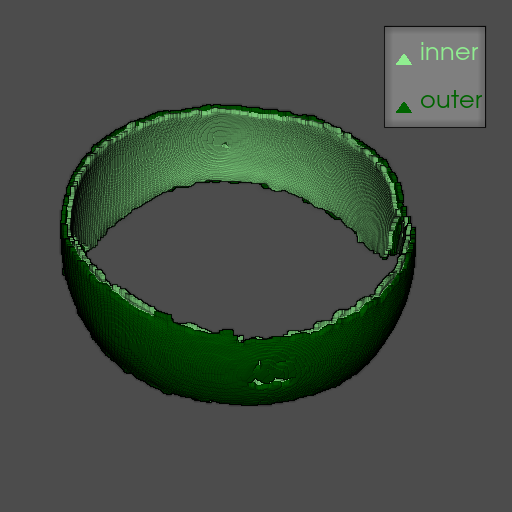

In [5]:
# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0) 
p0.enable_eye_dome_lighting()
colors = ['lightgreen', 'darkgreen']
for i, (key, p) in enumerate(points.items()):
    p0.add_mesh(p, color = colors[i], label=key)
p0.add_legend()
p0.camera_position = cpos['points']
_ = p0.show()

## Calculate intermembrane distances

In [6]:
# Gives refined and unrefined output in named tuple
dist_res = minimum_distance_refined(points['inner'], points['outer'])
dist_nm = dist_res.dist_refined*pix_size
points['inner_ref'] = dist_res.a_refined
points['outer_ref'] = dist_res.b_refined


# Calculate mean and std
dist_mean_nm = np.mean(dist_nm)
dist_std_nm = np.std(dist_nm)

# Save results in dictionary
d_dist = {'dist_values': dist_nm, 'dist_mean_nm': dist_mean_nm, 'dist_std_nm': dist_std_nm}
print("Mean refined distance {:.2f} nm, std {:.2f} nm".format(dist_mean_nm, dist_std_nm))

# Suffix for refined points
ref_suffix = '_ref'

Mean refined distance 8.87 nm, std 0.70 nm


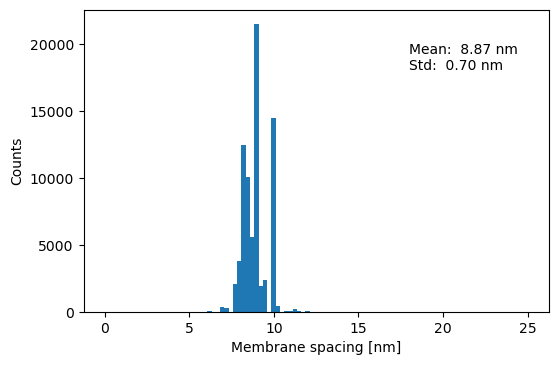

In [7]:
fig, ax = plt.subplots(dpi=100)
bins = np.linspace(0,25,100)

ax.hist(dist_nm, bins)
ax.text(18,0.8*ax.get_ylim()[1], "Mean: {:5.2f} nm \nStd: {:5.2f} nm".format(dist_mean_nm, dist_std_nm))

ax.set_xlabel('Membrane spacing [nm]')
ax.set_ylabel('Counts')
plt.show()

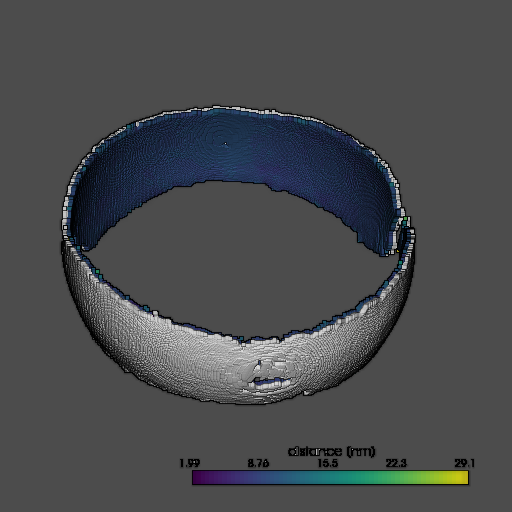

In [8]:
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()

p0.add_mesh(points['inner_ref'], scalars=dist_nm)
p0.add_scalar_bar(title='distance [nm]')
p0.add_mesh(points['outer_ref'], color='white')


p0.camera_position = cpos['points']
_ = p0.show()

### Optional: clean with clustering

In [19]:
# Additional cleaning step using clustering

if clean_points_clustering:
    out_ids = clean_pointlist_clustering([points['inner_ref'], points['outer_ref']])

    print('Found {} outliers in {} point pairs.'.format(len(out_ids), len(points['inner_ref'])))

    # Clean distances
    dist_nm_clean = np.delete(dist_nm, out_ids)
    dist_clean_mean_nm = np.mean(dist_nm_clean)
    dist_clean_std_nm = np.std(dist_nm_clean)
    print("Before: mean refined distance {:.2f} nm, std {:.2f} nm.".format(dist_mean_nm, dist_std_nm))
    print("After cleaning: mean refined distance {:.2f} nm, std {:.2f} nm".format(dist_clean_mean_nm, 
                                                                                  dist_clean_std_nm))
    # Clean points
    for key in ['inner_ref', 'outer_ref']:
        key_clean = key+'_clean'
        points[key_clean] = np.delete(points[key], out_ids, axis=0)
        
    # Update results
    d_dist.update({'dist_values_clean': dist_nm_clean, 
                   'dist_mean_nm_clean': dist_clean_mean_nm, 
                   'dist_std_nm_clean': dist_clean_std_nm})
    
    # Update suffix for refined points
    ref_suffix = '_ref_clean'

Found 10 outliers in 75806 point pairs.
Before: mean refined distance 8.87 nm, std 0.70 nm.
After cleaning: mean refined distance 8.87 nm, std 0.69 nm


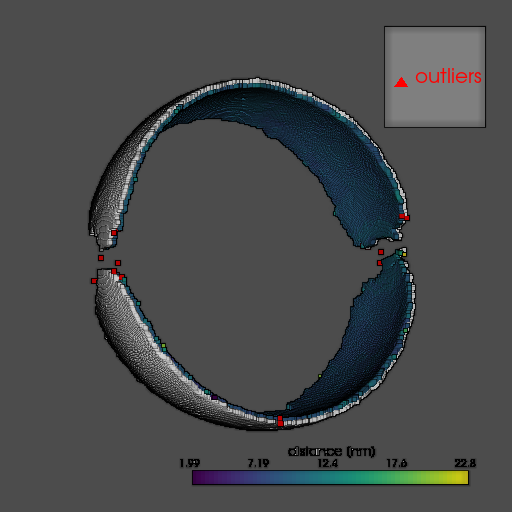

In [10]:
# Plot
if clean_points_clustering:
    p0 = pv.Plotter(notebook=True, window_size=window_size_0)
    p0.enable_eye_dome_lighting()

    p0.add_mesh(points['inner_ref_clean'], scalars=dist_nm_clean)
    p0.add_scalar_bar(title='distance [nm]')
    p0.add_mesh(points['outer_ref_clean'], color='white')

    p0.add_mesh(points['outer_ref'][out_ids], color='red', point_size=6, label='outliers')
    p0.add_mesh(points['inner_ref'][out_ids], color='red', point_size=6)
    p0.add_legend()
    p0.camera_position = cpos['outliers']
    _ = p0.show()

## Sphere and ellipsoid fits

Fitting of refined inner points.
Sphere fit: inner membrane radius is 354.5946353251342 nm
Sphere fit error is 2.782919971682329 nm
Ellipsoid fitting


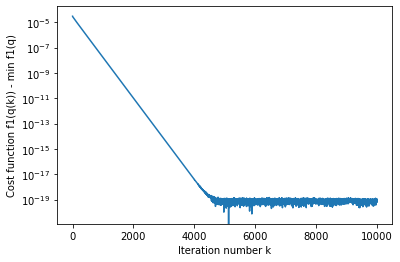

  0%|          | 13/75796 [00:00<10:00, 126.19it/s]

Calculating ellipsoid fit rmse...


100%|██████████| 75796/75796 [06:40<00:00, 189.16it/s]


Ellipsoid fit rmse is 0.8930106159199636 nm.
Sphericity index of best-fitting ellipsoid is 0.9889856800388603 for inner membrane.
Sphericity of best-fitting ellipsoid is 0.9999141165334422 for inner membrane.
Fitting of refined outer points.
Sphere fit: outer membrane radius is 363.34997217203306 nm
Sphere fit error is 2.7670439626112344 nm
Ellipsoid fitting


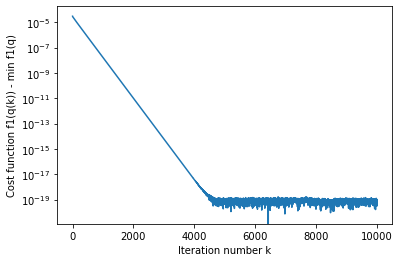

  0%|          | 15/75796 [00:00<08:48, 143.42it/s]

Calculating ellipsoid fit rmse...


100%|██████████| 75796/75796 [06:45<00:00, 186.99it/s]

Ellipsoid fit rmse is 0.851089491726799 nm.
Sphericity index of best-fitting ellipsoid is 0.9917623626769997 for outer membrane.
Sphericity of best-fitting ellipsoid is 0.9999065376482286 for outer membrane.


In [11]:
#Sphere and ellipsoid fitting of inner and outer points

# Dictionary for results
d_fit = {}
# Loop over inner and outer points
for label in ["inner", "outer"]:
    print(f'Fitting of refined {label} points.')
    p_tmp = points[label+ref_suffix]
    dt = {} # temporary dict
    
    # Sphere fit
    dt["sphere_center"], dt["sphere_radius"], dt["sphere_rmse"] = ls_sphere_3(p_tmp) # least squares fit
    dt["sphere_radius_nm"] = dt["sphere_radius"]*pix_size
    print("Sphere fit: {} membrane radius is {} nm".format(label, dt["sphere_radius_nm"]))
    print("Sphere fit error is {} nm".format(dt["sphere_rmse"]*pix_size))
    
    # Ellipsoid fit
    # subsample to make things faster 
    n_points = p_tmp.shape[0]
    if n_points > ellipsoid_fit_samplesize:
        points_sorted = p_tmp[ np.argsort(p_tmp[:,2]), : ] # sort points by z value
        sample_step = int(n_points // ellipsoid_fit_samplesize)
    
        points_sample = p_tmp[0::sample_step].copy() # try homogeneous subsampling with respect to z
    else:
        points_sample = p_tmp
    
    print('Ellipsoid fitting')
    ell_res = fit_ellipsoid_iter(points_sample, n_iter = n_iter_ellipsoid_fit, 
                                 plot_CF=True, return_CF=True)
    dt["ellipsoid_center"], dt["ellipsoid_axes"], dt["ellipsoid_rotmat"], dt["ellipsoid_residual"], dt["ellipsoid_CF"] = ell_res
    # Check convergence of ellipsoid fit, re-run if necessary
    if check_convergence_ellipsoid_fit(dt["ellipsoid_CF"], n_iter_ellipsoid_fit):
        dt["ellipsoid_fit_converged"] = True
        dt["ellipsoid_fit_n_iter"] = n_iter_ellipsoid_fit
    else :
        print('Ellipsoid fit did not converge in first run, re-try with {} iterations.'.format(n_iter_ell_run2))
        ell_res = fit_ellipsoid_iter(points_sample, n_iter = n_iter_ell_run2, plot_CF=True, return_CF=True)
        dt["ellipsoid_center"], dt["ellipsoid_axes"], dt["ellipsoid_rotmat"], dt["ellipsoid_residual"], dt["ellipsoid_CF"] = ell_res
        
        if check_convergence_ellipsoid_fit(dt["ellipsoid_CF"], n_iter_ellipsoid_fit):
            dt["ellipsoid_fit_converged"] = True
            dt["ellipsoid_fit_n_iter"] = n_iter_ell_run2
        else:
            print("Ellipsoid still not converged in run 2.")
            dt["ellipsoid_fit_converged"] = False
            dt["ellipsoid_fit_n_iter"] = n_iter_ell_run2
    
    if dt["ellipsoid_fit_converged"]:
        # If ellipsoid fit converged, also calculate rmse and other parameters  
        print('Calculating ellipsoid fit rmse...')
        dt["ellipsoid_rmse"] = ellipsoid_fit_rmse(p_tmp, dt["ellipsoid_axes"], dt["ellipsoid_center"], 
                                                  dt["ellipsoid_rotmat"], return_full=False)    
        print('Ellipsoid fit rmse is {} nm.'.format(dt["ellipsoid_rmse"]*pix_size))
        dt["ellipsoid_axes_nm"] = dt["ellipsoid_axes"]*pix_size
        
        # Sphericity (two measures, sphericity index and "classical" sphericity)                
        dt["sphericity_index"] = sphericity_index_ellipsoid(dt["ellipsoid_axes"])
        print("Sphericity index of best-fitting ellipsoid is {} for {} membrane.".format(dt["sphericity_index"], label))
        
        dt["sphericity_classical"] = sphericity_of_ellipsoid(dt["ellipsoid_axes"], verbose=False)
        print("Sphericity of best-fitting ellipsoid is {} for {} membrane.".format(dt["sphericity_classical"], label))

    # Save results into dictionary
    d_fit[label] = dt


In [12]:
# Plot

surf_ell = generate_ellipsoid_even(d_fit['inner']['ellipsoid_axes'], 
                                   d_fit['inner']['ellipsoid_center'], 
                                   d_fit['inner']['ellipsoid_rotmat'], 
                                   n_points=1000, 
                                   return_mesh=True, return_angles=False)

surf_sphere = generate_sphere_even(d_fit['inner']['sphere_radius'], 
                                   d_fit['inner']['sphere_center'], 
                                   n_points=1000, 
                                   return_mesh=True)

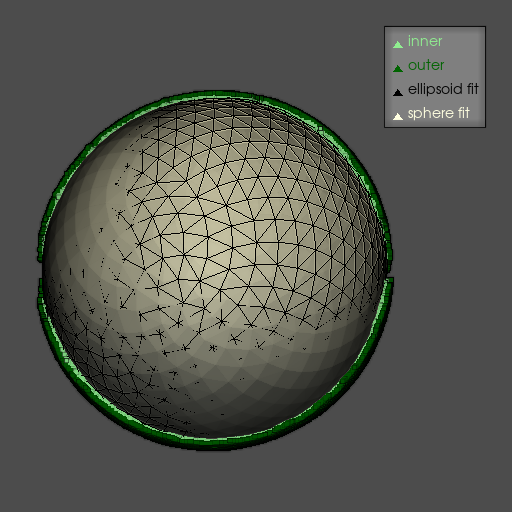

In [13]:
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()

p0.add_mesh(points['inner'+ref_suffix], color='lightgreen', label='inner')
p0.add_mesh(points['outer'+ref_suffix], color='darkgreen', label='outer')
p0.add_mesh(surf_ell, style='wireframe', color='black', label='ellipsoid fit')
p0.add_mesh(surf_sphere, color='lightyellow', label='sphere fit')
p0.add_legend()

p0.camera_position = cpos['fits']
_ = p0.show()

## Estimate the membrane area and intermembrane lumen

In [14]:
# Membrane areas estimated as surface areas of ellipsoids (determined with Knud Thomsen approximation)
Area_ellipsoid_inner_nm2 = ellipsoid_area_thomsen(d_fit['inner']['ellipsoid_axes_nm'])
Area_ellipsoid_outer_nm2 = ellipsoid_area_thomsen(d_fit['inner']['ellipsoid_axes_nm'] + dist_mean_nm) # don't use fit, estimate from inner + dist_mean_nm!

Area_total_nm2 = Area_ellipsoid_inner_nm2 + Area_ellipsoid_outer_nm2 # Total membrane area in nm^2

# Volume: adjust for membrane thickness
Volume_ellipsoid_inner_nm3 = ellipsoid_volume(d_fit['inner']['ellipsoid_axes_nm'] + 0.5*membrane_thickness)
Volume_ellipsoid_outer_nm3 = ellipsoid_volume(d_fit['inner']['ellipsoid_axes_nm'] + dist_mean_nm - 0.5*membrane_thickness)

Volume_lumen_nm3 = Volume_ellipsoid_outer_nm3 - Volume_ellipsoid_inner_nm3

# Area / lumen ratio
Area_volume_ratio = Area_total_nm2 / Volume_lumen_nm3

print("The area to lumen ratio is estimated as {:2.4f} 1/nm.".format(Area_volume_ratio))

The area to lumen ratio is estimated as 0.5168 1/nm.


In [15]:
# Estimate the corresponding vesicle radius
# solve the following equation for r: ratio = 3*r^2 / (r-thickness)^3 => 3*r^2 / (r-thickness)^3 - ratio = 0
def ratio_to_radius(ratio, membrane_thickness=membrane_thickness): 
    r = symbols('r')
    expr = (3 * r**2) / (r-0.5*membrane_thickness)**3 - ratio
    radius = solve(expr,r)[0]
    return radius

Corr_vesicle_radius = ratio_to_radius(Area_volume_ratio)
print("The corresponding vesicle diameter is {:2.4f} nm.".format(Corr_vesicle_radius*2))

The corresponding vesicle diameter is 23.6637 nm.


## Save results or compare to previously saved results

In [16]:
# Make one dictionary and turn all named tuples into dictionaries for saving
res_dict = {'dist': d_dist,
            'fit': d_fit,
            'AV_ratio': {'Area_total_nm2': Area_total_nm2, 
                         'Volume_lumen_nm3': Volume_lumen_nm3,
                         'Area_volume_ratio': Area_volume_ratio}}

res_dict_all = namedtuple_to_dict(res_dict)
overwrite_res_dict = False

# Save dictionaries with np.save as npy files
if overwrite_res_dict:
    np.save(fname_compare, res_dict_all)

In [17]:
# Load and compare

# Load reference
res_dict_ref = np.load(fname_compare, allow_pickle=True).item()

if dicts_all_equal(res_dict_ref, res_dict_all):
    print('Results are identical to previously saved ones.')
else:
    print('Check: results are not identical with previously saved ones.')

Results are identical to previously saved ones.
